In [1]:
### Auxiliary Functions
import matplotlib.pyplot as plt

def line_chart(ax: plt.Axes, xvalues: list, yvalues: list, title: str, xlabel: str, ylabel: str, percentage=False):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if percentage:
        ax.set_ylim(0.0, 1.0)
    ax.plot(xvalues, yvalues)

def multiple_line_chart(ax: plt.Axes, xvalues: list, yvalues: dict, title: str, xlabel: str, ylabel: str, percentage=False):
    legend: list = []
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if percentage:
        ax.set_ylim(0.0, 1.0)
    for name, y in yvalues.items():
        ax.plot(xvalues, y)
        legend.append(name)
    ax.legend(legend, loc='best', fancybox = True, shadow = True)   
    
def plot_roc_chart(ax: plt.Axes, models: dict, tstX, tstY, target: str='class'):
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('FP rate')
    ax.set_ylabel('TP rate')
    ax.set_title('ROC chart for %s'%target)
    ax.plot([0, 1], [0, 1], color='navy', label='random', linestyle='--')    
    for clf in models:
        scores = models[clf].predict_proba(tstX)[:,1]
        fpr, tpr, _ = metrics.roc_curve(tstY, scores, 'positive')
        roc_auc = metrics.roc_auc_score(tstY, scores)
        ax.plot(fpr, tpr, label='%s (auc=%0.2f)' %(clf, roc_auc))
    ax.legend(loc="lower center")



# Description

##### The goal of this project is to apply data science techniques to discover information in two distinct datasets. The second dataset predicts forest cover type from cartographic variables only. It includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedKFold

data = pd.read_csv('covtype.csv', sep=',')

data.shape

(581012, 55)

In [3]:
data.head(5)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [4]:
data.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In [5]:
cat_vars = data.select_dtypes(include='category')
cat_vars.columns.size

0

In [6]:
num_vars = data.select_dtypes(include='number')
num_vars.columns.size

55

In [7]:
null_vars = {}
for var in data:
    nas = data[var].isna().sum()
    if nas > 0:
        null_vars[var] = nas
print(len(null_vars))

0


##### The dataset has half a million records and 55 attributes, all numeric, and does not have any null values, just like the first dataset

### Reducing Sample Size

In [8]:
X = data.drop(columns=['Cover_Type'])
y = data['Cover_Type'].values

In [9]:
print("X", X.shape)
print("y", y.shape)

X (581012, 54)
y (581012,)


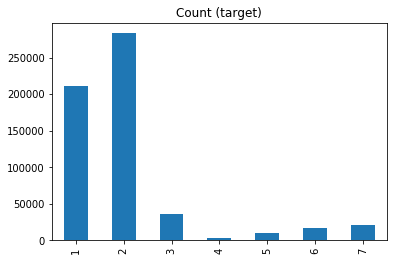

In [10]:
y_series = pd.Series(y)
target_count = y_series.value_counts().sort_index()
target_count.plot(kind='bar', title='Count (target)');

In [11]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

sampler = RandomUnderSampler(random_state=12)
X_res, y_res = sampler.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Using TensorFlow backend.


Resampled dataset shape Counter({1: 2747, 2: 2747, 3: 2747, 4: 2747, 5: 2747, 6: 2747, 7: 2747})


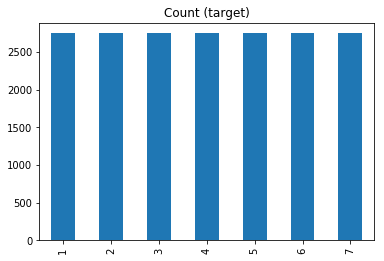

In [12]:
y_res_series = pd.Series(y_res)
target_count_res = y_res_series.value_counts().sort_index()
target_count_res.plot(kind='bar', title='Count (target)');

In [13]:
print("X", X_res.shape)
print("y", y_res.shape)

X (19229, 54)
y (19229,)


# Classification

##### For the covertype dataset, the target variable is 'Cover_Type' with a range from 1 to 7.

### Training Strategy

In [115]:
# Hold-Out 
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, 
                                                    test_size=0.3, 
                                                    random_state=13, 
                                                    stratify=y_res)

### KNN

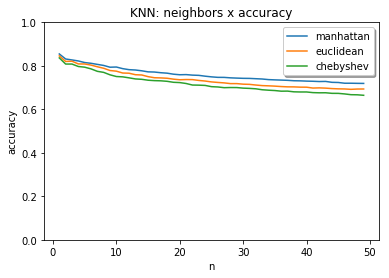

In [116]:
n_neighbors = range(1,50)
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
for d in dist:
    accuracy_values = []
    for n in n_neighbors:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(X_train, y_train)
        y_predict = knn.predict(X_test)
        accuracy_values.append(metrics.accuracy_score(y_test, y_predict))
    values[d] = accuracy_values
plt.figure()
multiple_line_chart(plt.gca(), n_neighbors, values, 'KNN: neighbors x accuracy', 'n', 'accuracy', percentage=True)
plt.show()

In [117]:
def average(lst): 
    return sum(lst) / len(lst) 

for d in values:
    print(round(average(values[d]),2))

0.76
0.74
0.72


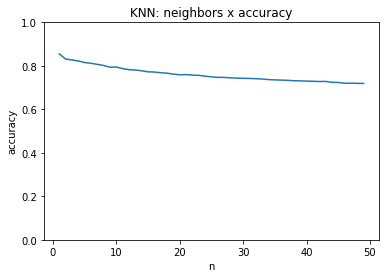

In [72]:
n_neighbors = range(1,50)
values = {}
for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n, metric='manhattan')
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    values[n] = metrics.accuracy_score(y_test, y_predict)
plt.figure()
line_chart(plt.gca(), values.keys(), values.values(), 'KNN: neighbors x accuracy', 'n', 'accuracy', percentage=True)
plt.show()

In [73]:
max(zip(values.values(), values.keys()))

(0.8547408563009187, 1)

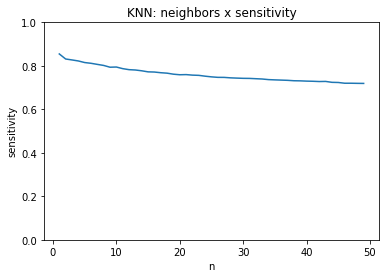

In [130]:
n_neighbors = range(1,50)
values = {}
for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n, metric='manhattan')
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    values[n] = metrics.recall_score(y_test, y_predict, average='micro')
plt.figure()
line_chart(plt.gca(), values.keys(), values.values(), 'KNN: neighbors x sensitivity', 'n', 'sensitivity', percentage=True)
plt.show()

In [128]:
max(zip(values.values(), values.keys()))

(0.8547463539696548, 1)

In [129]:
pd.Series([*values.values()]).mean()

0.7603013577136819

##### The 'manhattan' distance function presents the best accuracy for the model. The highest accuracy and sensitivity value corresponds to a model of 1 neighbor.


In [132]:
knn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
    
print("Neighbors: 1")
print("Accuracy: ", round(metrics.accuracy_score(y_test, y_predict),2))
print("Precision: ", round(metrics.precision_score(y_test, y_predict, average='micro'),2))
print("Sensitivity: ", round(metrics.recall_score(y_test, y_predict, average='micro'),2))
print("F1-score: ", round(metrics.f1_score(y_test, y_predict, average='micro'),2))

Neighbors: 1
Accuracy:  0.85
Precision:  0.85
Sensitivity:  0.85
F1-score:  0.85


In [133]:
# Confusion Matrix
import itertools
import matplotlib.pyplot as plt
CMAP = plt.cm.Reds

def plot_confusion_matrix(ax: plt.Axes, cnf_matrix: np.ndarray, classes_names: list, normalize: bool = False):
    if normalize:
        total = cnf_matrix.sum(axis=1)[:, np.newaxis]
        cm = cnf_matrix.astype('float') / total
        title = "Normalized confusion matrix"
    else:
        cm = cnf_matrix
        title = 'Confusion matrix'
    np.set_printoptions(precision=2)
    tick_marks = np.arange(0, len(classes_names), 1)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes_names)
    ax.set_yticklabels(classes_names)
    ax.imshow(cm, interpolation='nearest', cmap=CMAP)
    fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt), horizontalalignment="center")

<Figure size 432x288 with 0 Axes>

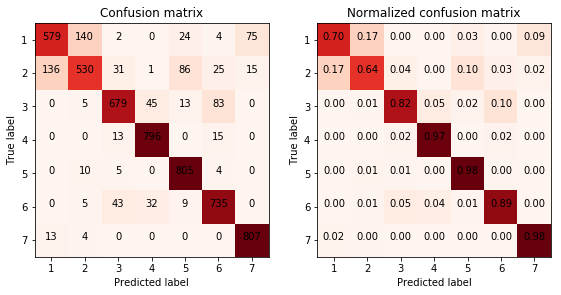

In [153]:
knn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
knn.fit(X_train, y_train)

labels: np.ndarray = pd.unique(y)
y_predict: np.ndarray = knn.predict(X_test)
cnf_mtx: np.ndarray = metrics.confusion_matrix(y_test, y_predict, labels.sort())

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
plot_confusion_matrix(axs[0,0], cnf_mtx, labels)
plot_confusion_matrix(axs[0,1], metrics.confusion_matrix(y_test, y_predict, labels), labels, normalize=True)
plt.tight_layout()
plt.show()

# Unsupervised Learning

##### Since this is an unsupervised technique we removed the target column, 'Cover_Type'. 

In [59]:
data_unsup = data.copy()
data_unsup = data_unsup.drop(columns=['Cover_Type'])
data_unsup.shape

(581012, 54)

In [60]:
data_unsup.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,0
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,0
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,0
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,0
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,0


##### Reducing Sample Size

In [61]:
sel_data = data_unsup.iloc[10000:20000]
sel_data.shape

(10000, 54)

##### Normalization

In [62]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scale_data = scaler.fit_transform(sel_data)
scale_data = pd.DataFrame(scale_data, columns=sel_data.columns)

In [63]:
scale_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0.743367,0.902778,0.180328,0.022762,0.217893,0.387230,0.678571,0.825806,0.712551,0.090478,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.745918,0.983333,0.180328,0.045524,0.225108,0.383092,0.734694,0.787097,0.635628,0.088248,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.745408,0.983333,0.180328,0.145675,0.287157,0.347029,0.729592,0.780645,0.635628,0.075701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.743878,0.302778,0.540984,0.045524,0.274170,0.270618,1.000000,0.535484,0.109312,0.106511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.732653,0.280556,0.573770,0.022762,0.242424,0.266923,0.989796,0.458065,0.060729,0.109438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [64]:
scale_data.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

### Association Rule Mining - Equal-width discretization

In [24]:
for col in scale_data:
    if col not in ['Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4',
                  'Soil_Type1','Soil_Type2','Soil_Type3','Soil_Type4','Soil_Type5','Soil_Type6',
                  'Soil_Type7','Soil_Type9','Soil_Type10','Soil_Type11','Soil_Type12','Soil_Type13',
                  'Soil_Type14','Soil_Type15','Soil_Type16','Soil_Type17','Soil_Type18','Soil_Type19',
                  'Soil_Type20','Soil_Type21','Soil_Type22','Soil_Type23','Soil_Type24','Soil_Type25',
                  'Soil_Type26','Soil_Type27','Soil_Type28','Soil_Type29','Soil_Type30','Soil_Type31',
                  'Soil_Type32','Soil_Type33','Soil_Type34','Soil_Type35','Soil_Type36','Soil_Type37',
                  'Soil_Type38','Soil_Type39','Soil_Type40']:
        scale_data[col] = pd.cut(scale_data[col],5,labels=['1','2','3','4','5'])
scale_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,4,5,1,1,2,2,4,5,4,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,4,5,1,1,2,2,4,4,4,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,4,5,1,1,2,2,4,4,4,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,2,3,1,2,2,5,3,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,2,3,1,2,2,5,3,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
dummylist = []
for att in scale_data:
    dummylist.append(pd.get_dummies(scale_data[[att]]))
dummi_data = pd.concat(dummylist, axis=1)
dummi_data.head(5)

,Elevation_1,Elevation_2,Elevation_3,Elevation_4,Elevation_5,Aspect_1,Aspect_2,Aspect_3,Aspect_4,Aspect_5,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0,0,0,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,0,0,1,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,0,1,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [26]:
dummi_data.shape

(10000, 98)

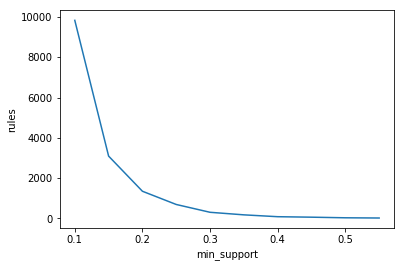

In [27]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

minsup = np.arange(0.1,0.6,0.05)
values = {}
for s in minsup:
    frequent_itemsets = apriori(dummi_data, min_support=s, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
    values[s] = len(rules.index)
plt.figure()
line_chart(plt.gca(), values.keys(), values.values(),'', 'min_support', 'rules', percentage=False)
plt.show()

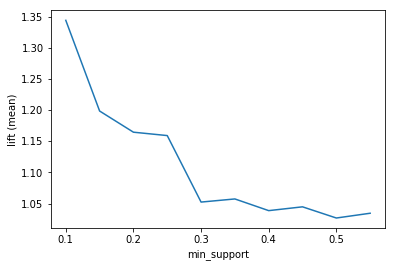

In [28]:
minsup = np.arange(0.1,0.6,0.05)
values = {}
for s in minsup:
    frequent_itemsets = apriori(dummi_data, min_support=s, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)
    values[s] = rules['lift'].mean()
plt.figure()
line_chart(plt.gca(), values.keys(), values.values(),'', 'min_support', 'lift (mean)', percentage=False)
plt.show() 

### Association Rule Mining - Equal-frequency discretization

In [65]:
for col in scale_data:
    if col not in ['Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4',
                  'Soil_Type1','Soil_Type2','Soil_Type3','Soil_Type4','Soil_Type5','Soil_Type6',
                  'Soil_Type7','Soil_Type8','Soil_Type9','Soil_Type10','Soil_Type11','Soil_Type12','Soil_Type13',
                  'Soil_Type14','Soil_Type15','Soil_Type16','Soil_Type17','Soil_Type18','Soil_Type19',
                  'Soil_Type20','Soil_Type21','Soil_Type22','Soil_Type23','Soil_Type24','Soil_Type25',
                  'Soil_Type26','Soil_Type27','Soil_Type28','Soil_Type29','Soil_Type30','Soil_Type31',
                  'Soil_Type32','Soil_Type33','Soil_Type34','Soil_Type35','Soil_Type36','Soil_Type37',
                  'Soil_Type38','Soil_Type39','Soil_Type40']:
        scale_data[col] = pd.qcut(scale_data[col],5,labels=['1','2','3','4','5'],duplicates='drop')     
scale_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,5,5,2,1,2,4,1,3,5,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,5,5,2,2,2,4,2,3,4,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,5,5,2,4,4,3,2,3,4,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5,3,5,2,4,3,5,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,3,5,1,3,3,5,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [66]:
dummylist = []
for att in scale_data:
    dummylist.append(pd.get_dummies(scale_data[[att]]))
dummi_data = pd.concat(dummylist, axis=1)
dummi_data.head(5)

,Elevation_1,Elevation_2,Elevation_3,Elevation_4,Elevation_5,Aspect_1,Aspect_2,Aspect_3,Aspect_4,Aspect_5,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0,0,0,0,1,0,0,0,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,1,0,0,0,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,1,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,0,0,0,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,0,0,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [67]:
dummi_data.shape

(10000, 94)

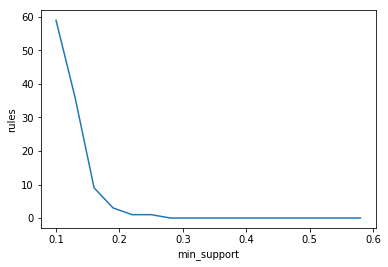

In [72]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

minsup = np.arange(0.1,0.6,0.03)
values = {}
for s in minsup:
    frequent_itemsets = apriori(dummi_data, min_support=s, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
    values[s] = len(rules.index)
plt.figure()
line_chart(plt.gca(), values.keys(), values.values(),'', 'min_support', 'rules', percentage=False)
plt.show()

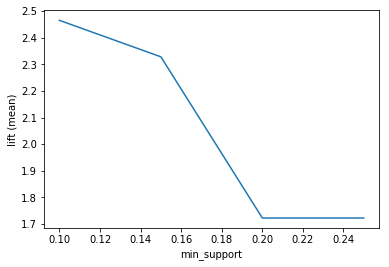

In [75]:
minsup = np.arange(0.1,0.6,0.05)
values = {}
for s in minsup:
    frequent_itemsets = apriori(dummi_data, min_support=s, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)
    values[s] = rules['lift'].mean()
plt.figure()
line_chart(plt.gca(), values.keys(), values.values(),'', 'min_support', 'lift (mean)', percentage=False)
plt.show() 